# Practical: Scape Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# data structure for triangular maps / scapes
from triangularmap import ArrayTMap, TMap

# library for creating (pitch) scape plots (and pitch-scape clustering)
import pitchscapes as ps

from muprocdurham.jupyter import no_linebreaks
from muprocdurham import seed_everything

seed_everything(42)
no_linebreaks()

## Manually compute scape

### Basics

In [2]:
# helper functions to plot/print a TMap
def plot_tmap(tmap, axis_off=True, ax=None):
    ps.plotting.scape_plot_from_array(
        tmap.reindex_from_top_down_to_start_end(tmap.arr),  # different indexing conventions
        ax=ax,                                              # if you want to plot to an existing axis
        plot_kwargs=dict(axis_off=axis_off),                # passed on to ps.plotting.scape_plot
    )

def print_tmap(tmap):
    print(tmap.pretty(rnd=dict(decimals=3)))

You can easily create and visualise scalar scapes.

                   ╱╲                   
                  ╱ 2╲                  
                 ╱╲  ╱╲                 
                ╱ 0╲╱ 0╲                
               ╱╲  ╱╲  ╱╲               
              ╱ 0╲╱ 0╲╱ 0╲              
             ╱╲  ╱╲  ╱╲  ╱╲             
            ╱ 0╲╱ 0╲╱ 0╲╱ 0╲            
           ╱╲  ╱╲  ╱╲  ╱╲  ╱╲           
          ╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲          
         ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲         
        ╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲        
       ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲       
      ╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 3╲╱ 0╲      
     ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲     
    ╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲    
   ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲   
  ╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲  
 ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲  ╱╲ 
╱ 0╲╱ 1╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲╱ 0╲


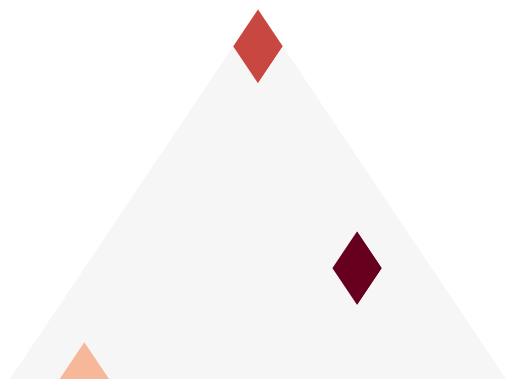

In [3]:
tmap = ArrayTMap(n=10, value=0)
tmap[1, 2] = 1
tmap[0, 10] = 2
tmap[5, 9] = 3
print_tmap(tmap)
plot_tmap(tmap)

If you have 3 or 4 values, these are interpreted as RGB(A) values.

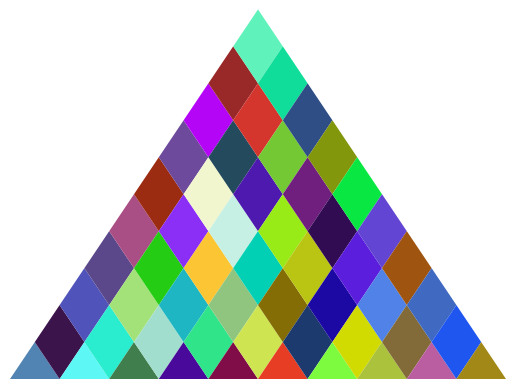

In [4]:
tmap = ArrayTMap(n=(10, 3), value=0)
tmap._arr = np.random.random(tmap.arr.shape)
plot_tmap(tmap)

### Compute scape

Define a `feature` function that extracts information from a sequence, such as `mean`, `min`, `max`, `sum`. Use this to define a `compute_scape` function that fills the scape cell by cell.

First couple of values in sequence:
[[0.8353025  0.32078006 0.18651851]
 [0.04077514 0.59089294 0.67756436]
 [0.01658783 0.51209306 0.22649578]
 [0.64517279 0.17436643 0.69093774]
 [0.38673535 0.93672999 0.13752094]]


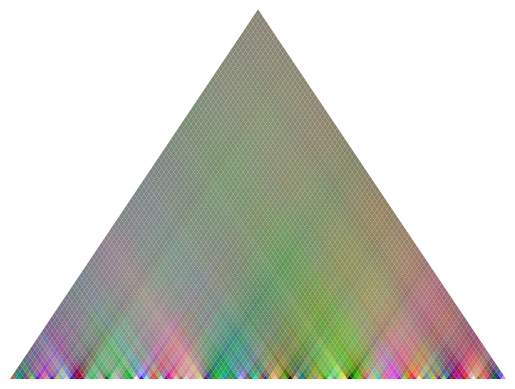

In [5]:
def feature(sequence):
    # vvvvvvvvvvvvvvvv
    # which axis to compute features over
    # axis = None  # compute over all dimensions
    axis = 0     # computer only along sequence, keep other dimensions
    return sequence.mean(axis=axis)
    # return sequence.max(axis=axis)
    # return sequence.min(axis=axis)
    # ^^^^^^^^^^^^^^^^

def compute_scape(sequence):
    # initialise TMap with correct dimensions
    value = feature(sequence)
    tmap = ArrayTMap(n=(sequence.shape[0],) + value.shape, value=np.zeros_like(value))
    # iterate through all cells and assign feature value
    # vvvvvvvvvvvvvvvvvvvvvvvvvvv
    for start in range(tmap.n + 1):
        for end in range(start + 1, tmap.n + 1):
            tmap[start, end] = feature(sequence[start:end])
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return tmap

sequence = np.random.random((100, 3))
print(f"First couple of values in sequence:\n{sequence[:5]}")
tmap = compute_scape(sequence)
plot_tmap(tmap)

## The `pitchscapes` library

The `pitchscapes` library is specialised for sum features over irregular time intervals, in particular, pitch-class counts/distributions.

### `DiscreteScape`

The most basic type is `DiscreteScape`, which is defined on arbitrary discrete time intervals and returns the weighted sum over the sequence of values. Go through the code below, look at how the defaults for `times` and `weights` are defined, and relate this to what was discussed in the lecture about weighting notes and summing over time intervals.

In [6]:
for weights in [None, np.ones(5) * 10]:
    for times in [None, [0, 1.5, 2, 2, 4, 5]]:
        scape = ps.scapes.DiscreteScape(
            values=[1, 1, 1000, 2, 1], 
            weights=weights,
            times=times,
        )
        print("values: ", scape.values)
        print("times:  ", scape.times, "<--", times)
        print("weights:", scape.weights, "<--", weights)
        print("[0, 5]: ", scape[0, 5])
        print()

values:  [   1    1 1000    2    1]
times:   [0 1 2 3 4 5] <-- None
weights: [1 1 1 1 1] <-- None
[0, 5]:  1005

values:  [   1    1 1000    2    1]
times:   [0.  1.5 2.  2.  4.  5. ] <-- [0, 1.5, 2, 2, 4, 5]
weights: [1.5 0.5 0.  2.  1. ] <-- None
[0, 5]:  7.0

values:  [   1    1 1000    2    1]
times:   [0 1 2 3 4 5] <-- None
weights: [10. 10. 10. 10. 10.] <-- [10. 10. 10. 10. 10.]
[0, 5]:  10050.0

values:  [   1    1 1000    2    1]
times:   [0.  1.5 2.  2.  4.  5. ] <-- [0, 1.5, 2, 2, 4, 5]
weights: [10. 10. 10. 10. 10.] <-- [10. 10. 10. 10. 10.]
[0, 5]:  10050.0



### `ContinuousScape`

Because real time is continuous, `ContinuousScape` wraps `DiscreteScape` and interpolates between the discrete time points to provide accurate values for arbitrary time intervals.

In [7]:
scape = ps.scapes.ContinuousScape(values=[0, 1, 1, 10])
print(scape.scape.times)
print(scape[3, 4])
print(scape[3.5, 4])

[0 1 2 3 4]
10
5.0


Write a `sample_scape` function that
 - takes a `ContinuousScape`
 - samples values on a uniform time grid with resolution `n`
 - re-normalises these values (to get the mean over time instead of the sum)
 - and stores them in a `TMap`.

**Hints:**
 - `scape.max_time` and `scape.min_time` give you the minimum and maximum time
 - for re-normalising, you need to divide by the time interval that was summed over
 - to work with multi-dimensional values, you can get their shape and initialise your `TMap` as `ArrayTMap((n,) + shape, value)`

In [8]:
def sample_scape(n, scape):
    # vvvvvvvvvvvvvvvvvvvvv
    tmap = None
    time_scaling = (scape.max_time - scape.min_time) / n
    time_offset = scape.min_time
    for start in range(n + 1):
        for end in range(start + 1, n + 1):
            value = scape[start * time_scaling + time_offset, end * time_scaling + time_offset] / ((end - start) * time_scaling)
            if tmap is None:
                try:
                    shape = value.shape
                except AttributeError:
                    shape = (1,)
                shape = (n,) + shape
                tmap = ArrayTMap(shape, value)
            tmap[start, end] = value
    # ^^^^^^^^^^^^^^^^^^^^^
    return tmap

You can use this to plot a continuous scape by over-sampling on a finer time grid.

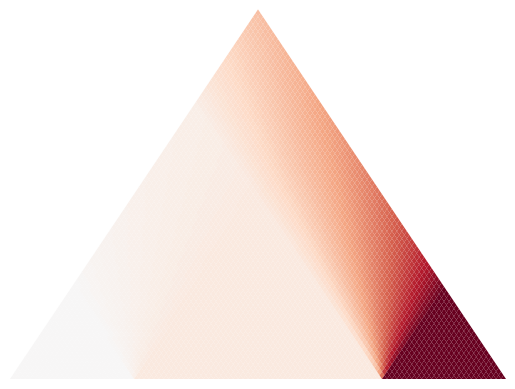

In [9]:
scape = ps.scapes.ContinuousScape(values=[0, 1, 1, 10])
tmap = sample_scape(100, scape)
plot_tmap(tmap)

If your implementation also works with multi-dimensional values, you can do the same with colours.

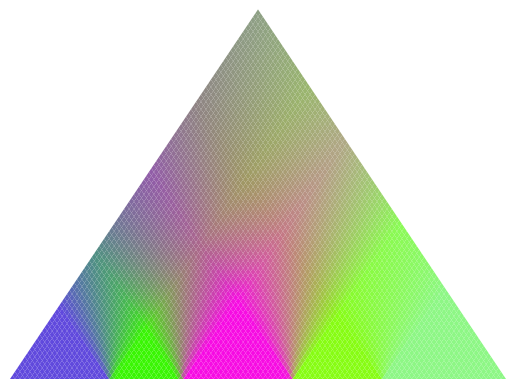

In [10]:
values = np.random.random((5, 3))
times = np.arange(len(values) + 1) + np.random.random(len(values) + 1)
scape = ps.scapes.ContinuousScape(values=values, times=times)
tmap = sample_scape(100, scape)
plot_tmap(tmap)

### `PitchScape`

A `PitchScape` is a `ContinuousScape` (typically with 12 values for the 12 pitch classes) returns averages over time (instead of sums) and additionally handles normalisation of input and output values as well as prior counts.

With three dimensions and without normalisation or prior counts, this is the same as what you did manually above.

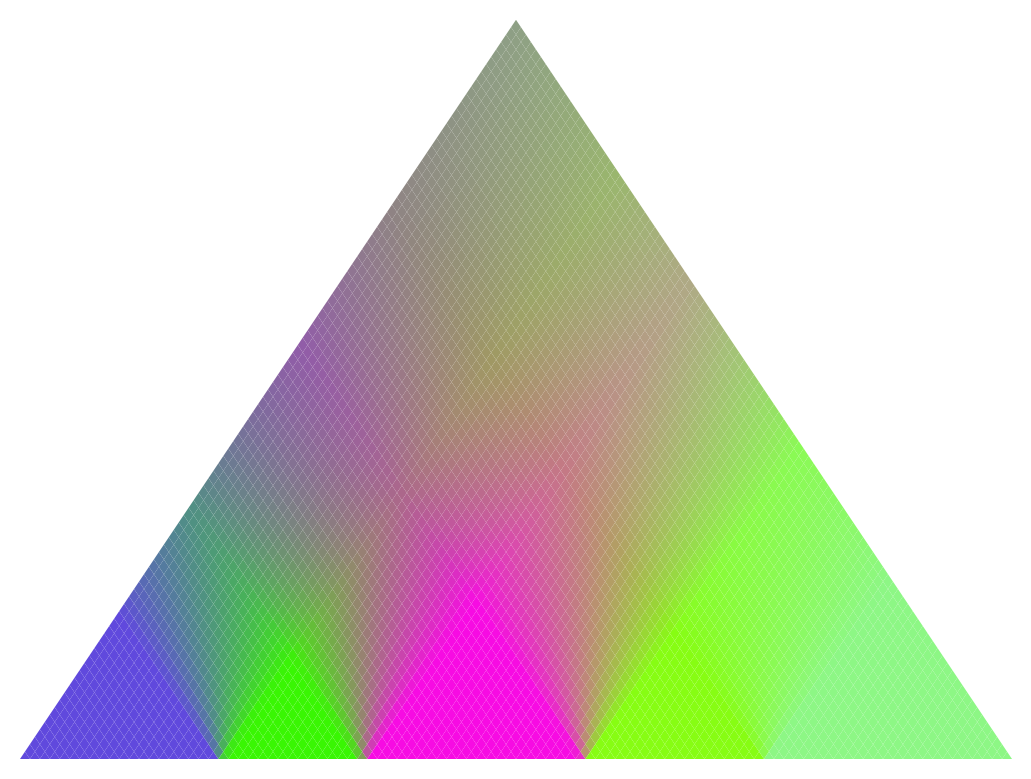

In [11]:
scape = ps.scapes.PitchScape(
    values=values,
    times=times,
)
tmap = sample_scape(100, scape)
plot_tmap(tmap)

With normalisation and prior counts, it does the following (as discussed in the lecture):

- it normalises inputs (i.e. simultaneously sounding notes do not get the full weight)
- it adds prior counts _after_ summing over time
- it re-normalises the outputs (as done manually above)

see **Technical Details** below if it is of interest.

### Key-Scape Plots

Based on this, we can create key-scape plots. The `get_pitch_scape` function readings in a piece and creates a `PitchScape`.

In [12]:
scape_JSB = ps.reader.get_pitch_scape('Prelude_No_1_BWV_846_in_C_Major.mid')
scape_LvB = ps.reader.get_pitch_scape('Sonata_No._14_Op._27_No._2_-_Ludwig_van_Beethoven.mid')

This can be turned into colours using a key-finding algorithm with two default colour palettes based on chromatic order or the circle of fifths.

(<Figure size 1200x200 with 1 Axes>, <Axes: >)

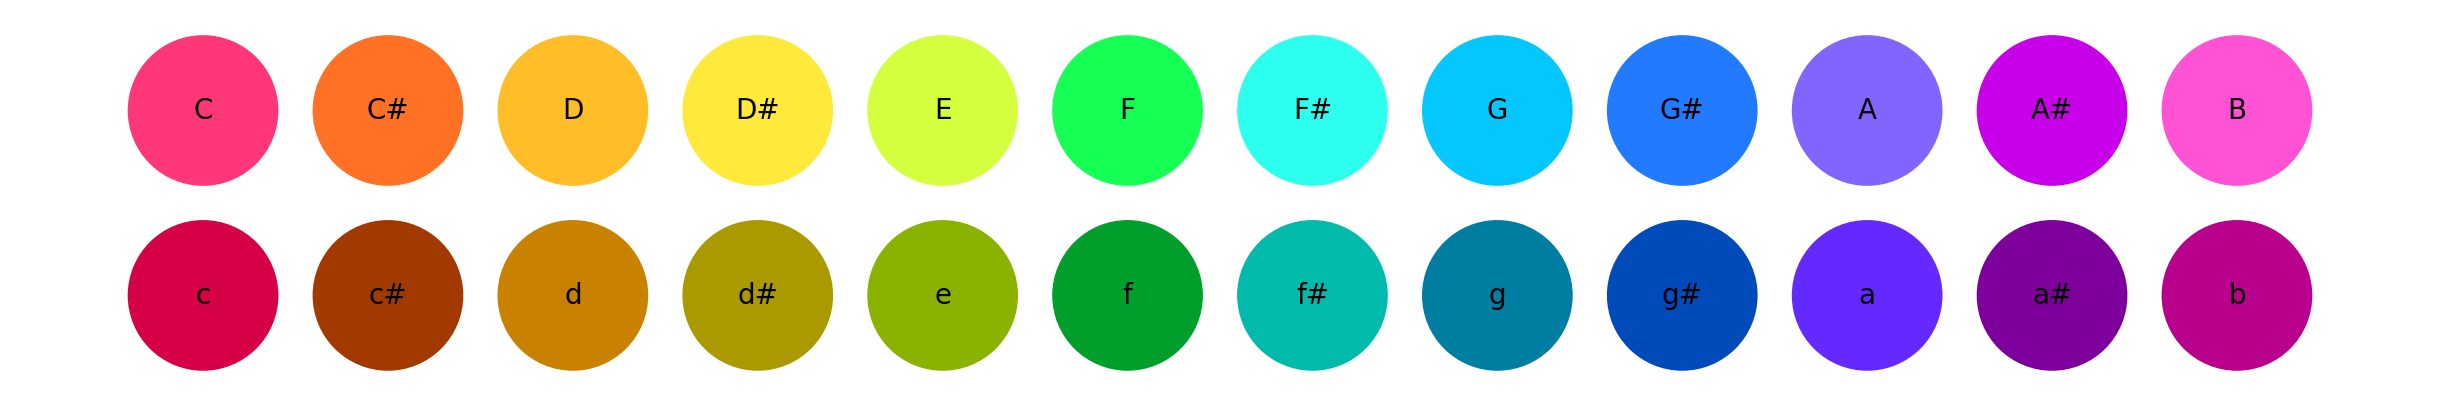

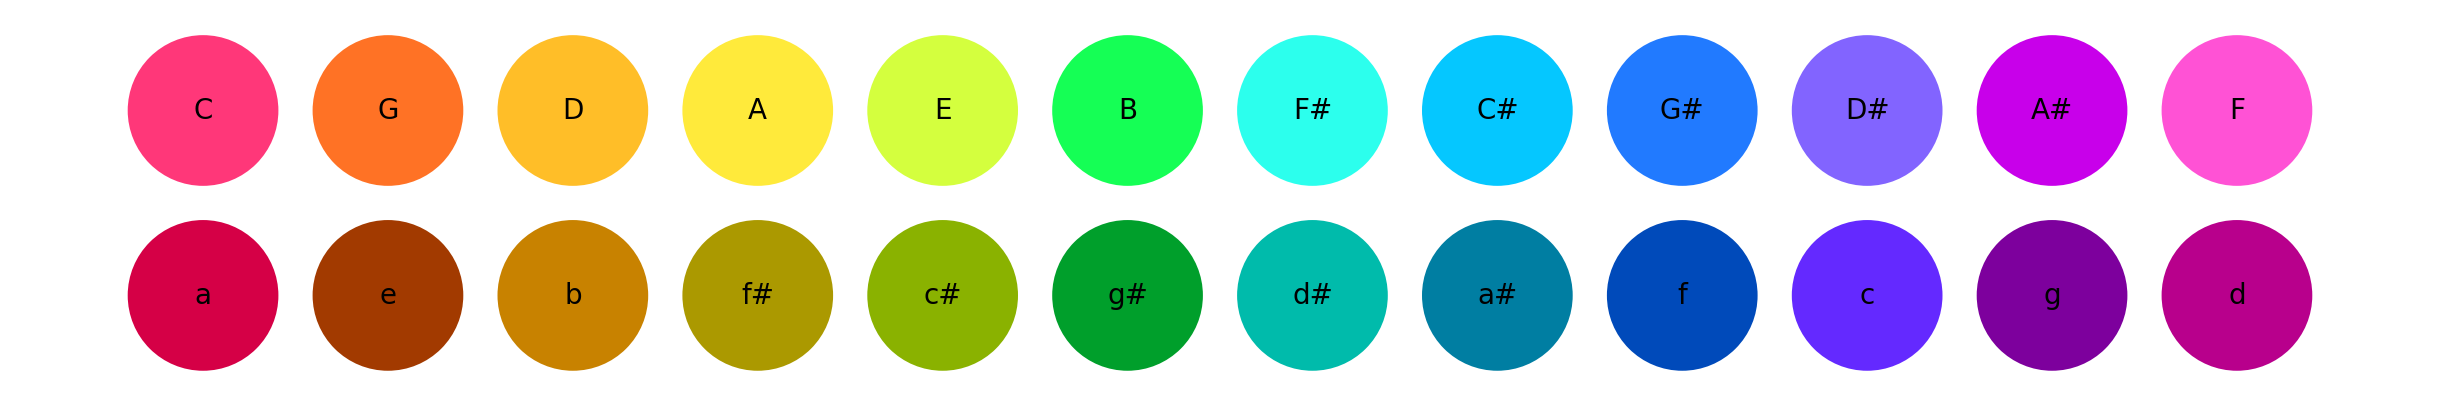

In [13]:
ps.plotting.key_legend()
ps.plotting.key_legend(circle_of_fifths=True)

The `key_scape_plot` function performs this conversion and plots the resulting key scapes.

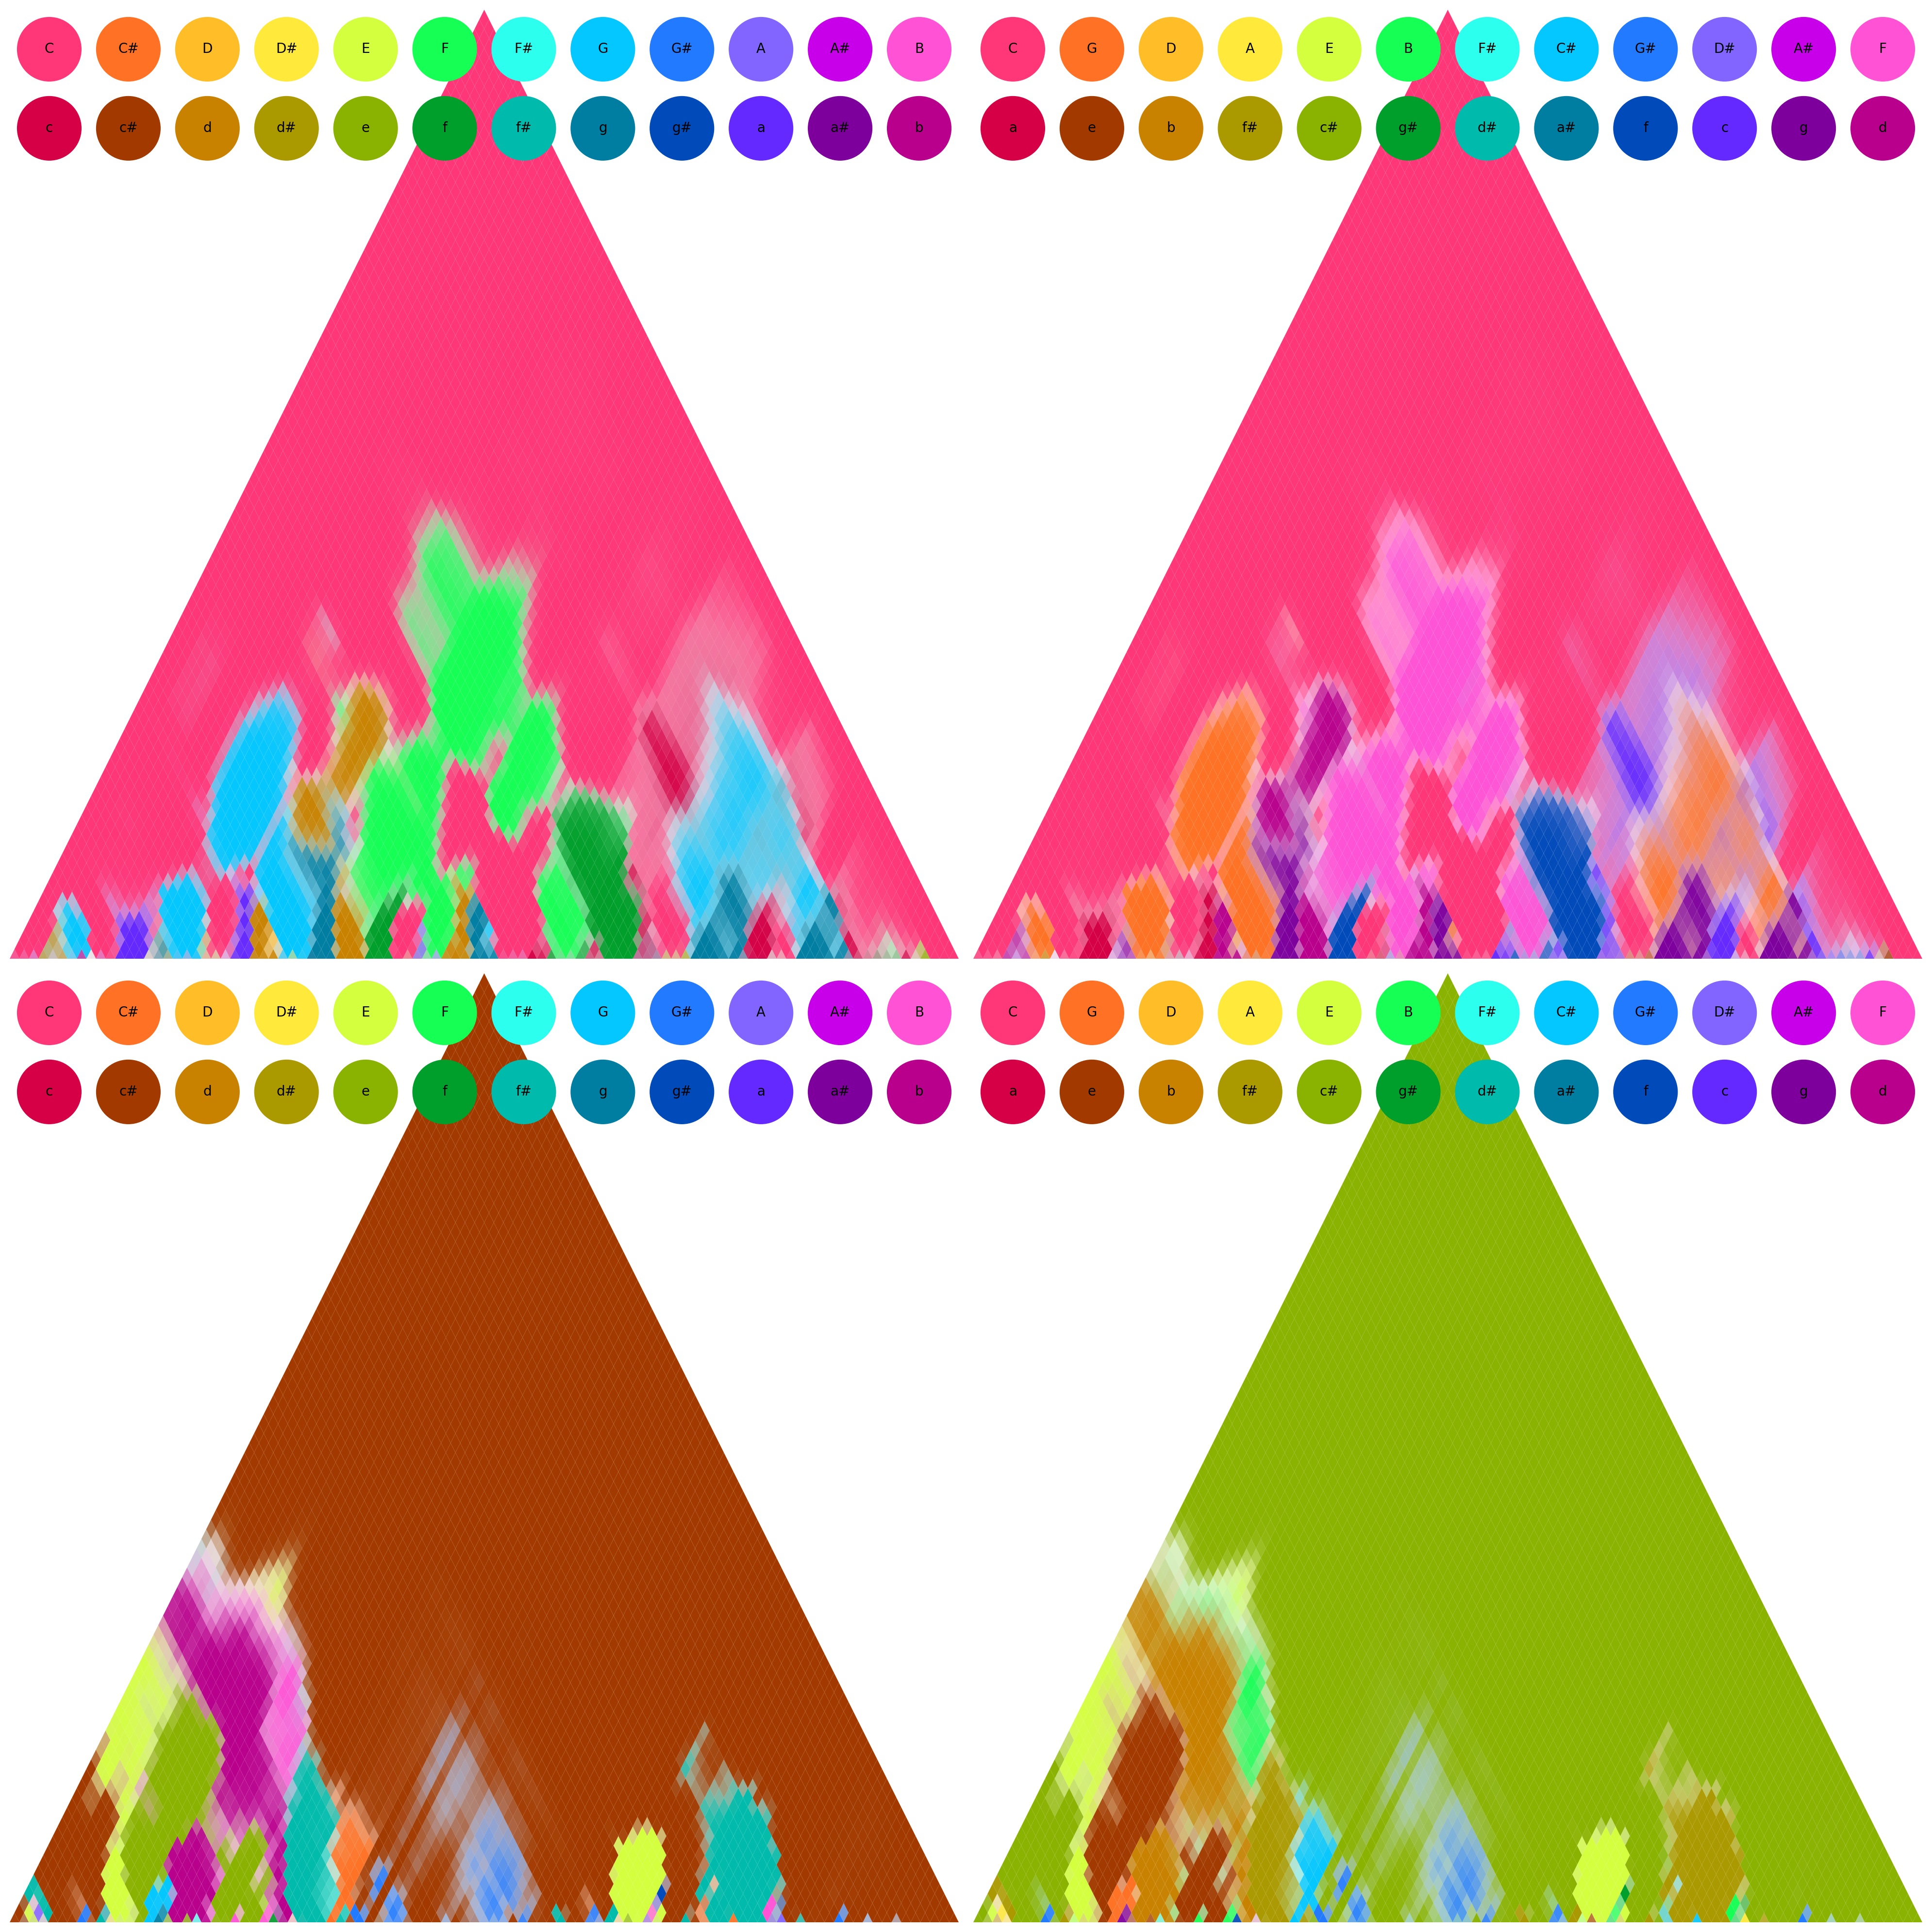

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
ps.plotting.key_scape_plot(scape=scape_JSB, n_samples=100, ax=axes[0, 0])
ps.plotting.key_scape_plot(scape=scape_JSB, n_samples=100, ax=axes[0, 1], circle_of_fifths=True);
ps.plotting.key_scape_plot(scape=scape_LvB, n_samples=100, ax=axes[1, 0])
ps.plotting.key_scape_plot(scape=scape_LvB, n_samples=100, ax=axes[1, 1], circle_of_fifths=True);
fig.tight_layout()

Learning pitch-scape clusters from a corpus of data is a bit more involved, have a look at the [Tutorial](https://github.com/robert-lieck/pitchscapes/blob/master/Tutorial.ipynb) if you are interested in this.

## Parsing Pitch Scapes

Since these plots look so "tree-ish", we can try to somehow extract tree structures from them, similar to parse trees in grammars. But instead of performing full CYK parsing to obtain the trees, we can attempt to use a much simpler approach by greedily merging bottom-up.

Write a `greedy_merge` function that takes a sequence of points:
 - each point is a $k$-dimensional vector ($k=12$ for pitch class distributions)
 - compute pairwise distances between adjacent points in that sequence
 - pick the pair with minimum distance
 - merge the pair:
     - create a new point (e.g. by computing the mean of the merged points)
     - replace the merged pair by the new point
 - use a `TMap` to store the values by keeping track of the span of each point

Below is a skeleton for the `greedy_merge` function. Experiment on the simple colour scapes from above to see if equal colours are merged first. Once that is working, you can add additional preferences based on the start and end indices (e.g. to merge small sub-trees first or to prefer merging trees of equal size). Finally, you can test on the real musical examples!

Here are some helper functions (adapted from [here](https://cognitivecomputinglab.github.io/snippets/auto_examples/plot_tree_from_tmap.html)) for visualising the resulting trees.

In [15]:
def get_branches(tmap, _start=None, _end=None):
    """
    Return a list of branches from the tree encoded in the binary TMap

    :param tmap: Binary TMap with encoded tree
    :param _start: for internal recursion only: start of the sub-tree
    :param _end: for internal recursion only: end of the sub-tree
    :return: list of [[(parent_start, parent_end), (child_start, child_end)], ...] branches
    """
    if not (_start is None) == (_end is None):
        raise ValueError("Either start and end have to be BOTH provided or none of them.")
    branch_list = []
    if _start is None:
        _start = 0
        _end = tmap.n
    # left child
    left_branch = [(_start, _end)]
    left_start = _start
    for left_end in range(_end - 1, _start, -1):
        if tmap[left_start, left_end]:
            left_branch.append((left_start, left_end))
            break
    else:
        raise RuntimeError("Could not find left child")
    branch_list.append(left_branch)
    # right child
    right_branch = [(_start, _end)]
    right_end = _end
    for right_start in range(_start + 1, _end):
        if tmap[right_start, right_end]:
            right_branch.append((right_start, right_end))
            break
    else:
        raise RuntimeError("Could not find right child")
    branch_list.append(right_branch)
    # recurse
    if left_end - left_start > 1:
        branch_list += get_branches(tmap, _start=left_start, _end=left_end)
    if right_end - right_start > 1:
        branch_list += get_branches(tmap, _start=right_start, _end=right_end)
    return branch_list

def plot_tree(tmap, label_tmap=None, ax=None,
              node_kwargs=(), branch_kwargs=(), label_kwargs=(),
              x_y_from_start_end=None, axis_off=True, scale=(1, 1), set_lims=True):
    """
    Plot the nodes and branches from a tree encoded in a binary TMap.

    :param tmap: Binary TMap with tree
    :param ax: axis to plot to or None (default)
    :param node_kwargs: key-word arguments passed to the scatter() plot call for nodes
    :param branch_kwargs: key-word arguments passed to the plot() call for the branches
    :param x_y_from_start_end: function to map (start, end) parts to (x, y) coordinates; default is
     ``x = (start + end) / 2`` and ``y = end - start``.
    """
    try:
        x_scale, y_scale = scale
    except TypeError:
        x_scale, y_scale = scale, scale
    node_kwargs = {**dict(s=1, c=[(0.9, 0, 0)]), **dict(node_kwargs)}
    branch_kwargs = {**dict(lw=0.5, c='black'), **dict(branch_kwargs)}
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    # function to map (start, end) parts to (x, y) coordinates
    if x_y_from_start_end is None:
        def x_y_from_start_end(start, end):
            return (start + end) / 2, end - start
    # plot nodes
    x, y = [], []
    for start in range(tmap.n):
        for end in range(start + 1, tmap.n + 1):
            if tmap[start, end]:
                x_, y_ = x_y_from_start_end(start, end)
                x_ *= x_scale
                y_ *= y_scale
                x.append(x_)
                y.append(y_)
                if label_tmap is not None:
                    ax.annotate(label_tmap[start, end], (x_, y_), **dict(label_kwargs))
    ax.scatter(x=x, y=y, **dict(node_kwargs))
    # plot branches
    lines = []
    for (p_start, p_end), (c_start, c_end) in get_branches(tmap):
        if lines:
            lines.append((np.nan, np.nan))
        lines.append(x_y_from_start_end(p_start, p_end))
        lines.append(x_y_from_start_end(c_start, c_end))
    lines = np.array(lines) * [[x_scale, y_scale]]
    ax.plot(*lines.T, **dict(branch_kwargs))
    # layout
    if axis_off:
        ax.axis('off')
    if set_lims:
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(min(y), max(y))

def binary_tree_from_chart(chart):
    """Convert chart to binary TMap"""
    return TMap(np.isfinite(chart.arr.sum(axis=-1)))

Here is a skeleton for the `greedy-merge` function.

In [16]:
def greedy_merge(points):
    # get start and end indices
    starts = np.arange(len(points))
    ends = starts + 1
    
    # initialise a chart with nan (to be filled with values for merges)
    chart = ArrayTMap(n=points.shape, value=np.nan)
    # fill bottom level
    chart.lslice[1] = points
    
    # compute pairwise distances and greedily merge closest pair
    while len(points) > 1:
        # compute distances based on values
        # vvvvvvvvvvvvvvvvvvv
        distances = np.linalg.norm(points[:-1] - points[1:], axis=-1)
        distances += 0. * ((ends[:-1] - starts[:-1]) - (ends[1:] - starts[1:]))  # prefer merging equally-sized trees
        distances += 0.1 * ((ends[:-1] - starts[:-1]) + (ends[1:] - starts[1:]))  # prefer merging small trees
        # ^^^^^^^^^^^^^^^^^^^
        # pick closest pair
        min_idx = np.argmin(distances)
        # get points and their start and end index
        p1, s1, e1 = points[min_idx], starts[min_idx], ends[min_idx]
        p2, s2, e2 = points[min_idx + 1], starts[min_idx + 1], ends[min_idx + 1]
        # merge points using weighted average
        # vvvvvvvvvvvvvvvvvvv
        w1 = e1 - s1
        w2 = e2 - s2
        new_p = (w1 * p1 + w2 * p2) / (w1 + w2)
        # ^^^^^^^^^^^^^^^^^^^
        # update chart and lists
        chart[s1, e2] = new_p
        points = np.concatenate([points[:min_idx], [new_p], points[min_idx + 2:]], axis=0)
        starts = np.concatenate([starts[:min_idx], [s1], starts[min_idx + 2:]], axis=0)
        ends = np.concatenate([ends[:min_idx], [e2], ends[min_idx + 2:]], axis=0)

    return chart

You can visualise the results like this.

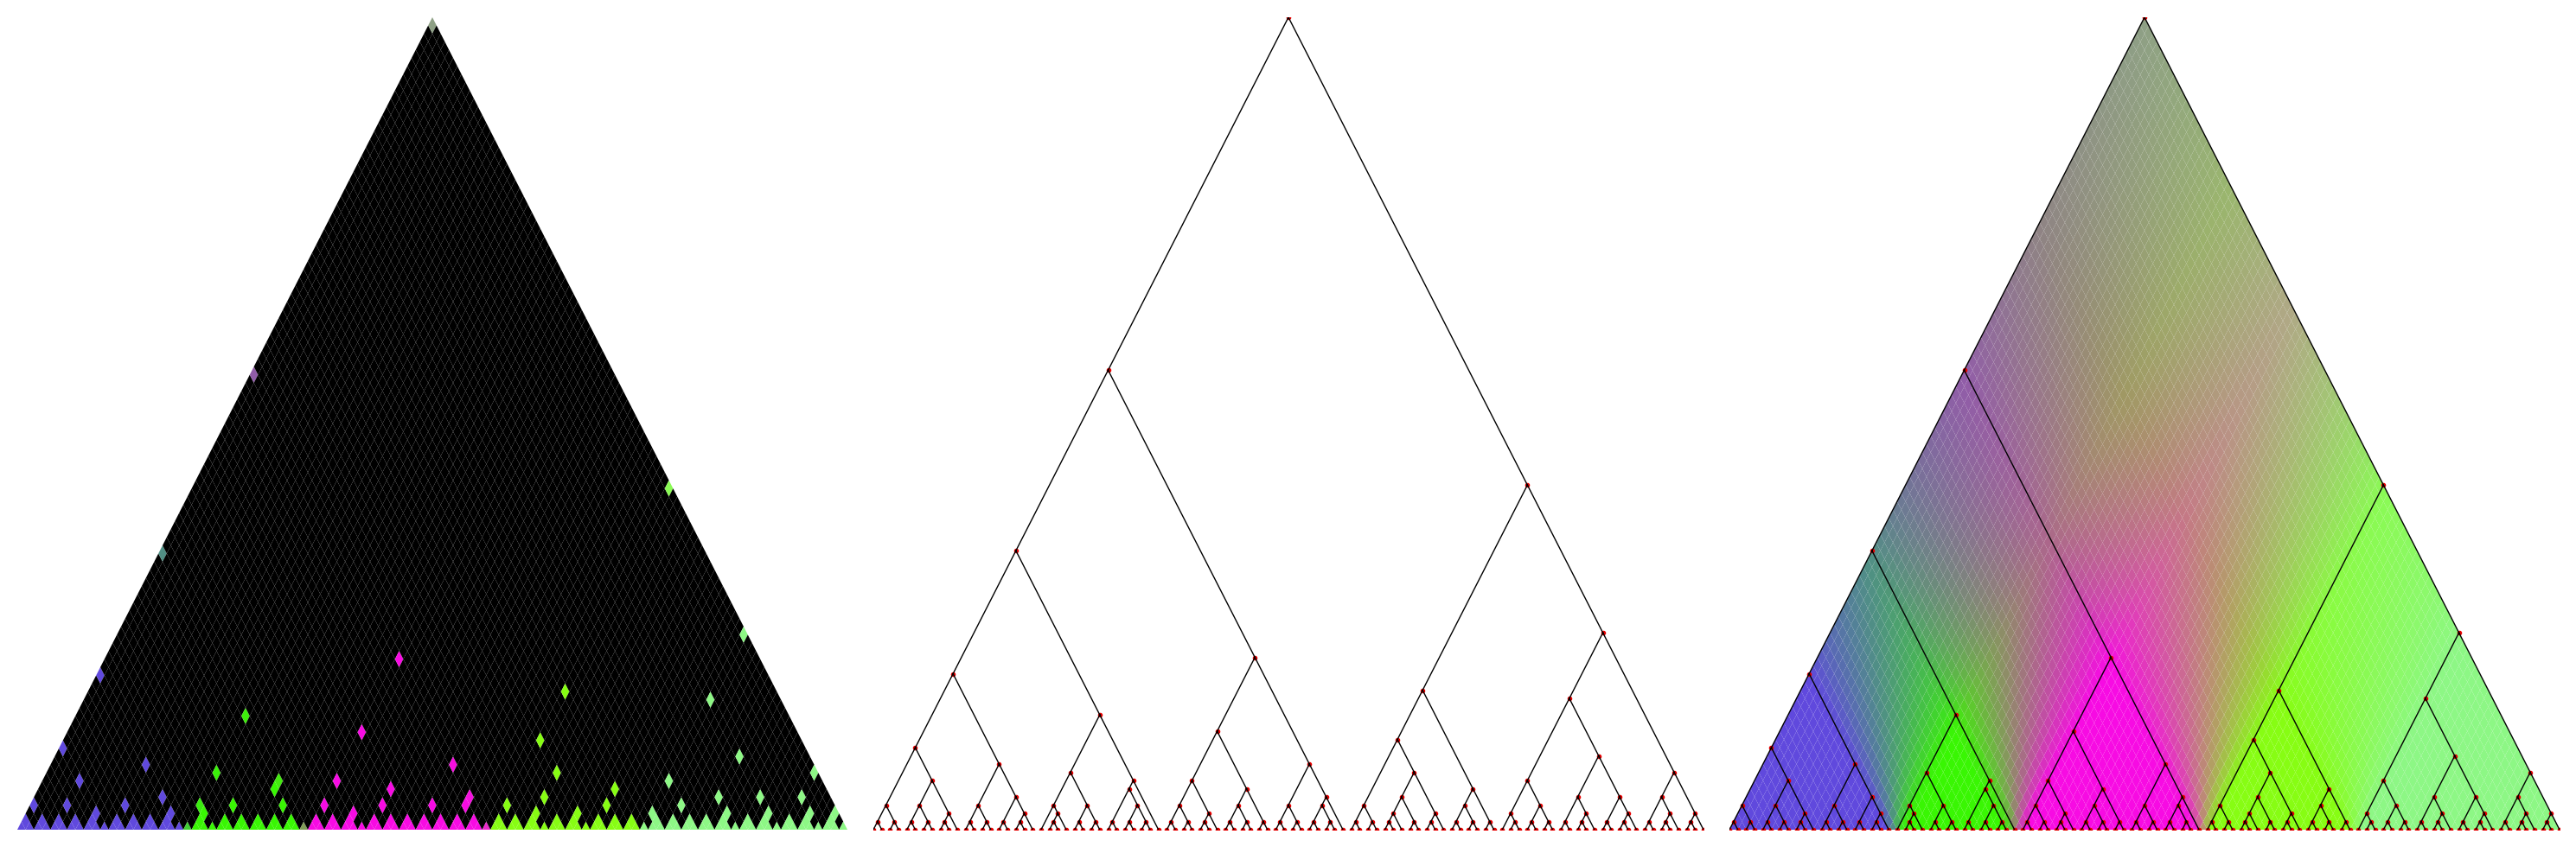

In [17]:
# parse scape (useing bottom level as input points)
chart = greedy_merge(tmap.lslice[1])

# create plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot values of merges
plot_tmap(chart, ax=axes[0])

# plot extrated tree
tree = binary_tree_from_chart(chart)
plot_tree(tree, ax=axes[1])

# overlay scape plot with tree
plot_tmap(tmap, ax=axes[2])
plot_tree(tree, ax=axes[2])

fig.tight_layout()

Now let's see how this works on real music data!

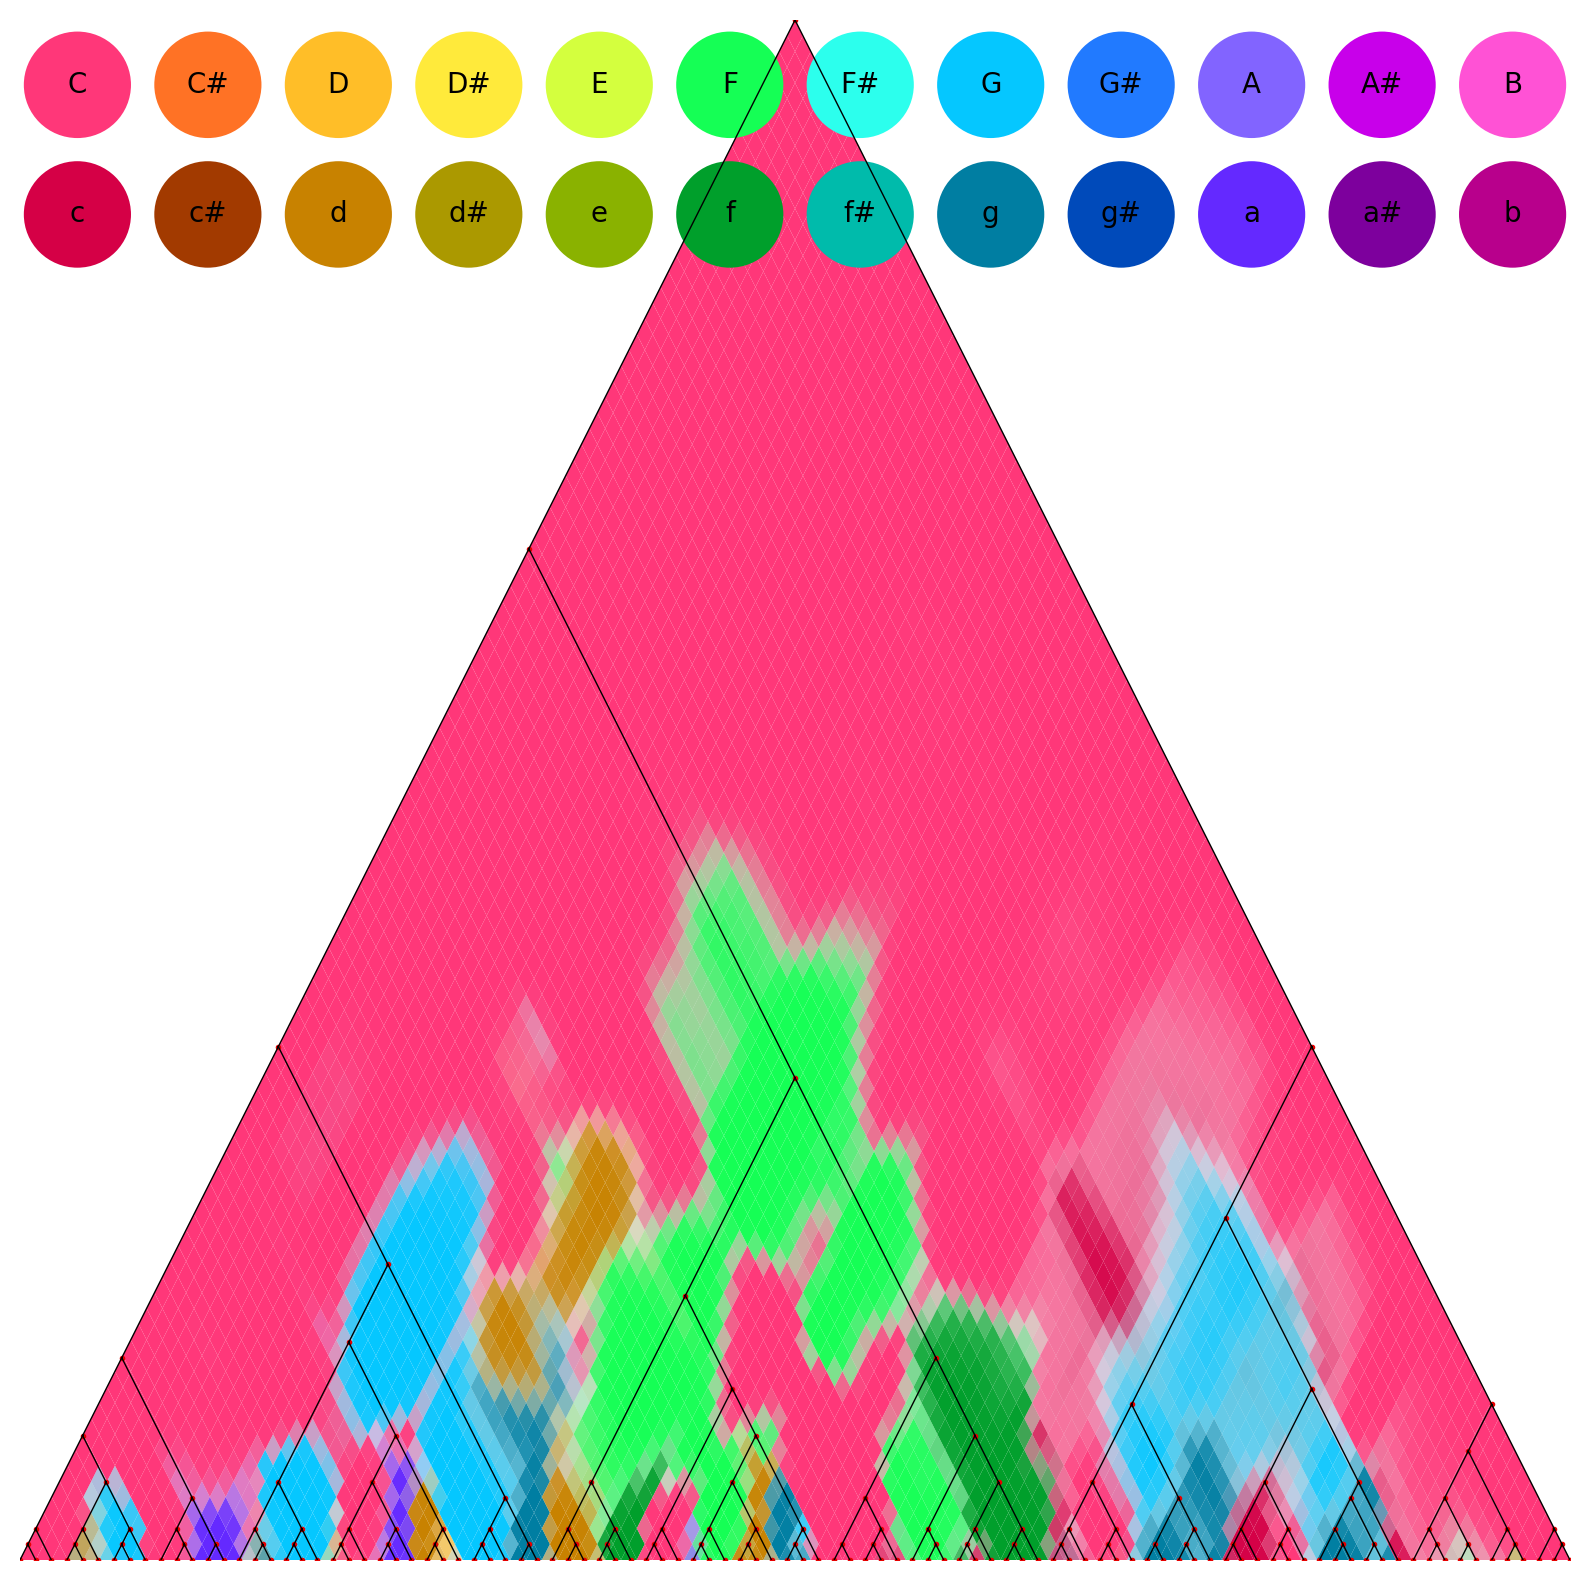

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# sample on fixed grid
n_samples = 100
scape = sample_scape(n_samples, scape_JSB)
# perform greedy merges
chart = greedy_merge(scape.lslice[1])
# get binary tree
tree = binary_tree_from_chart(chart)
# plot tree on top of pitch scape
ps.plotting.key_scape_plot(scape=scape_JSB, n_samples=n_samples, ax=ax)
plot_tree(tree, ax=ax, scale=1/n_samples)

## Technical Details

In [19]:
import inspect
# get_pitch_scape is just a shortcut
print(inspect.getsource(ps.reader.get_pitch_scape))

def get_pitch_scape(file_path, **kwargs):
    """
    Load a pitch scape from file.
    :param file_path: file to load
    :param kwargs: kwargs passed to PitchScape
    :return: PitchScape object
    """
    pitch_counts, times = pitch_class_counts(file_path)
    return PitchScape(values=pitch_counts, times=times, **kwargs)



In [20]:
# PitchScape is wrapper around ContinuousScape that does some additional
# things (e.g. adding prior counts and normalising if requested)
print(scape_JSB.scape)

In [21]:
for prior_counts in [0, 1, 10]:
    for normalise in [False, True]:
        print(f"\nnormalise: {normalise} | prior counts: {prior_counts}")
        # --------------
        # PitchScape
        # --------------
        print("PitchScape")
        scape_JSB = ps.reader.get_pitch_scape(
            'Prelude_No_1_BWV_846_in_C_Major.mid',
            normalise=normalise,        # normalise inputs AND outputs (default: False)
            prior_counts=prior_counts,  # add prior counts to all output counts (default: 0)
        )
        print(scape_JSB[0,    0.25].round(3))  # first sixteenth note
        print(scape_JSB[0.25, 0.5 ].round(3))  # second sixteenth note
        print(scape_JSB[0,    0.5 ].round(3))  # first two sixteenth notes

        # --------------
        # Manual Version
        # --------------
        print("Manual Version")
        pitch_counts, times = ps.reader.pitch_class_counts('Prelude_No_1_BWV_846_in_C_Major.mid')
        # normalise input values
        if normalise:
            pitch_counts = pitch_counts / pitch_counts.sum(axis=1, keepdims=True)
        # initialise continuous scape from that
        scape = ps.scapes.ContinuousScape(values=pitch_counts, times=times)
        # add prior counts to output
        v1 = scape[0,    0.25] + prior_counts
        v2 = scape[0.25, 0.5 ] + prior_counts
        v3 = scape[0,    0.5 ] + prior_counts
        # normalise output
        if normalise:
            v1 /= v1.sum()
            v2 /= v2.sum()
            v3 /= v3.sum()
        print(v1.round(3))
        print(v2.round(3))
        print(v3.round(3))


normalise: False | prior counts: 0
PitchScape
[0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.25 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.  ]
[0.5  0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.  ]
Manual Version
[0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.25 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.  ]
[0.5  0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.  ]

normalise: True | prior counts: 0
PitchScape
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.5 0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.75 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.  ]
Manual Version
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.5 0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.75 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.  ]

normalise: False | prior counts: 1
PitchScape
[1.25 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]
[1.25 1.   1.   1.   1.25 1.   1.   1.   1.   1.   1.   1.  ]
[1.5  1.   1.   1.   1.25 1.   1. 